# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
# --- Extension Setup ---
%load_ext autoreload
%load_ext line_profiler
%autoreload 2 -p

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Autoreload Target ---
%aimport afml

# --- AFML Initialization ---
import afml

# # --- Logging (Optional but Recommended) ---
# from loguru import logger
# from pathlib import Path

# # Optional: clear old logs
# log_path = Path("logs") / "afml_session.log"
# log_path.parent.mkdir(exist_ok=True)
# log_path.unlink(missing_ok=True)

# # Configure Loguru
# logger.add(log_path, level="INFO", rotation="10 MB", retention="10 days")
# logger.info("Session started")

# --- Environment Diagnostics ---
from pathlib import Path
print(f"Working Dir: {Path.cwd()}")


2025-09-12 05:29:28.026 | DEBUG    | afml.cache:_configure_numba:61 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-09-12 05:29:28.027 | INFO     | afml.cache:initialize_cache_system:310 - AFML cache system initialized:
2025-09-12 05:29:28.031 | INFO     | afml.cache:initialize_cache_system:311 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-09-12 05:29:28.033 | INFO     | afml.cache:initialize_cache_system:312 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-09-12 05:29:28.035 | INFO     | afml.cache:initialize_cache_system:318 -   Loaded stats: 8 functions, 26.4% hit rate
2025-09-12 05:29:36.680 | DEBUG    | afml.cache.selective_cleaner:_load_tracking_data:39 - Loaded tracking data for 17 functions


2025-09-12 05:29:41 | WARNING  | Some lightweight modules failed to import: No module named 'afml.labeling.performance_metrics'
2025-09-12 05:29:41 | INFO     | AFML v1.0.0 ready - 10 heavy modules available for lazy loading
Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [3]:
import warnings
import winsound
from datetime import datetime as dt
from datetime import timedelta
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import talib
from sklearn.ensemble import RandomForestClassifier

from afml.backtest_statistics import (
    calculate_performance_metrics,
    compare_pr_curves,
    compare_roc_curves,
    compare_roc_pr_curves,
    meta_labelling_classification_report_images,
    meta_labelling_classification_report_tables,
    meta_labelling_reports,
    run_meta_labeling_analysis,
)
from afml.bet_sizing.bet_sizing import bet_size_probability
from afml.cache import cache_maintenance, clear_afml_cache, selective_cache_clear
from afml.data_structures.bars import *
from afml.features import get_fractal_features, get_time_features, is_stationary
from afml.filters import cusum_filter
from afml.labeling import (
    add_vertical_barrier,
    get_event_weights,
    trend_scanning_labels,
    triple_barrier_labels,
)
from afml.mt5.load_data import (
    clean_tick_data,
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
)
from afml.strategies import (
    BollingerStrategy,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
)
from afml.strategies.training import train_meta_model
from afml.util import (
    CLEAN_DATA_PATH,
    COMMODITIES,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    GREEKS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    get_period_vol,
    smart_subscript,
    to_subscript,
    value_counts_data,
)

warnings.filterwarnings("ignore")
plt.style.use("dark_background")

In [ ]:
# from afml.cache.selective_cleaner import *

# pprint(cache_maintenance(), sort_dicts=False)
# clear_afml_cache()

## 1. Data Preparation

In [4]:
account = "FundedNext_STLR2_6K"
# account = "METAQUOTES_DEMO_25K"
# account = login_mt5(account)
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2021-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date

In [5]:
def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict.get(timeframe)
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
            print(f"Loading ticks from {CLEAN_DATA_PATH}...")
        except FileNotFoundError:
            print(f"Downloading ticks to {DATA_PATH}...")
            save_data_to_parquet(DATA_PATH, symbol, start_date, end_date, account)
            tick_df = load_tick_data(DATA_PATH, symbol, start_date, end_date, account, columns)
            tick_df = clean_tick_data(tick_df)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

## 2. Bollinger Band Strategy

In [6]:
from notebooks.plot_bands import plot_bbands, plot_bbands_dual_bbp_bw

In [7]:
bb_timeframe = "M5"
tick_bar_size = tick_bar_dict.get(bb_timeframe)
print(f"{bb_timeframe} = tick-{tick_bar_size}")
bb_time_bars, bb_tick_bars = get_data(symbol, bb_timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"

M5 = tick-200
Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


In [8]:
bb_period, bb_std = 20, 1.5 # Bollinger Band parameters
bb_strategy = BollingerStrategy(window=bb_period, num_std=bb_std)
bb_lookback = 10
bb_pt_barrier, bb_sl_barrier, bb_time_horizon = (1.5, 1, 50)
bb_vol_multiplier = 2

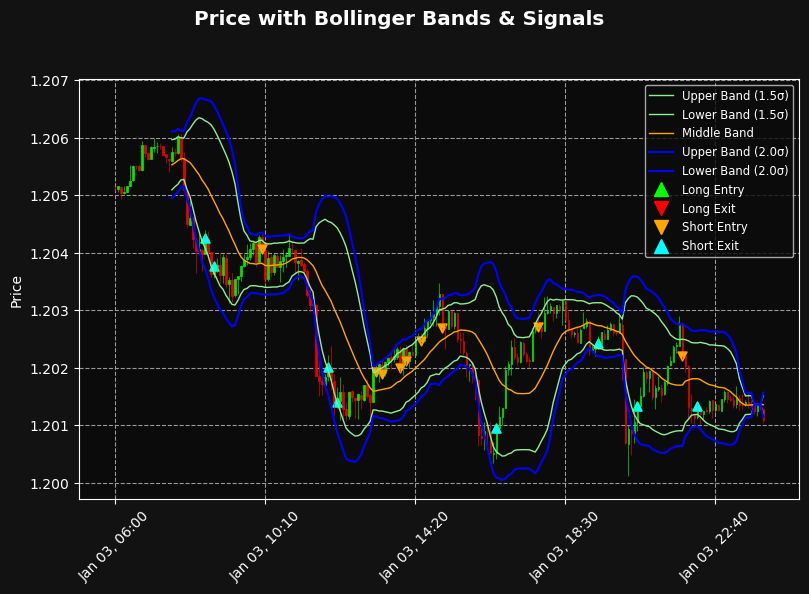

In [35]:
start, end = "2018-01-03 06:00", "2018-01-04 00:00"
plot_bbands(bb_time_bars, start, end, window=bb_period, std0=bb_std, std1=2, width=10, height=6, markersize=40)

### Time-Bars

In [ ]:
bb_side = bb_strategy.generate_signals(bb_time_bars)
bb_df = bb_time_bars.loc[sample_start : sample_end]
close = bb_df.close

# Volatility target for barriers
vol_target = get_daily_vol(close, lookback=20) * bb_vol_multiplier
vol_target.dropna(inplace=True)

thres = vol_target.mean()
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}")

# t_events = cusum_filter(close.reindex(vol_target.index), vol_target)
t_events = t_events.intersection(bb_side[bb_side != 0].index)
print(f"t_events: {t_events.size:,}")

vertical_barriers = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)
linear_decay = False

2025-09-12 02:05:45 | INFO     | 12,008 CUSUM-filtered events
CUSUM filter threshold: 0.1244%
t_events: 9,295


#### Feature Engineering

In [ ]:
bb_feat = create_bollinger_features(bb_time_bars, bb_lookback, bb_period, bb_std)
bb_feat_time = bb_feat.shift().dropna()
bb_feat_time.info()
# not_stationary = is_stationary(bb_feat_time)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 513293 entries, 2018-01-19 07:40:00 to 2024-12-31 00:00:00
Data columns (total 51 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   close             513293 non-null  float32
 1   spread            513293 non-null  float32
 2   bb_lower          513293 non-null  float32
 3   bb_upper          513293 non-null  float32
 4   bb_bandwidth      513293 non-null  float32
 5   bb_percentage     513293 non-null  float64
 6   ret               513293 non-null  float32
 7   ret_5             513293 non-null  float32
 8   ret_10            513293 non-null  float32
 9   ret_1_lag_1       513293 non-null  float32
 10  ret_5_lag_1       513293 non-null  float32
 11  ret_10_lag_1      513293 non-null  float32
 12  ret_1_lag_2       513293 non-null  float32
 13  ret_5_lag_2       513293 non-null  float32
 14  ret_10_lag_2      513293 non-null  float32
 15  ret_1_lag_3       513293 non-null 

#### Fixed-Time Horizon Method

In [ ]:
bb_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
bb_events_fh_time = bb_events_fh.copy()
print(f"Fixed-Time Horizon (h={bb_time_horizon}):")
value_counts_data(bb_events_fh.bin, verbose=True)


ret = bb_events_fh.ret
sr_bb_fh = ret.mean() / ret.std()

av_uniqueness = bb_events_fh['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Fixed-Time Horizon (h=50):

     count  proportion
bin                   
1    4,812    0.518199
0    4,474    0.481801

Average Uniqueness: 0.4878


#### Triple-Barrier Method

In [ ]:
bb_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tbl = get_event_weights(bb_events_tbl, close)
bb_events_tbl_time = bb_events_tbl.copy()

print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tbl.bin, verbose=True)

ret = bb_events_tbl.ret
sr_bb_tbl = ret.mean() / ret.std()
av_uniqueness = bb_events_tbl['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1.5, sl=1, h=50):

     count  proportion
bin                   
0    7,362    0.792806
1    1,924    0.207194

Average Uniqueness: 0.6646


#### Trend-Scanning Method

In [ ]:
span = (5, bb_period + 1)
volatility_threshold = 0.85
side = bb_side.reindex(t_events)

In [ ]:
trend_events = trend_scanning_labels(close, span, volatility_threshold)
trend_events = trend_events.reindex(t_events)
print(f"Trend-Scanning (σ = {volatility_threshold}):")
value_counts_data(trend_events.bin, verbose=True)

print(f"\nTriple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
av_uniqueness = bb_events_tbl_time['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")
value_counts_data(bb_events_tbl_time.bin, verbose=True)

bb_events_trend = bb_events_tbl_time.join(trend_events[['window', 't_value']])
bb_events_trend["bin"] = bb_events_trend["bin"].where(trend_events['bin'] == side, 0)
bb_events_trend_time = bb_events_trend.copy()

Trend-Scanning (σ = 0.85):

     count  proportion
bin                   
 0   7,120    0.766003
 1   1,099    0.118236
-1   1,076    0.115761


Triple-Barrier (pt=1.5, sl=1, h=50):
Average Uniqueness: 0.6646

     count  proportion
bin                   
0    7,362    0.792806
1    1,924    0.207194



Trend-Scanning Meta-labels (σ = 0.85):

     count  proportion
bin                   
0    9,031    0.972539
1      255    0.027461



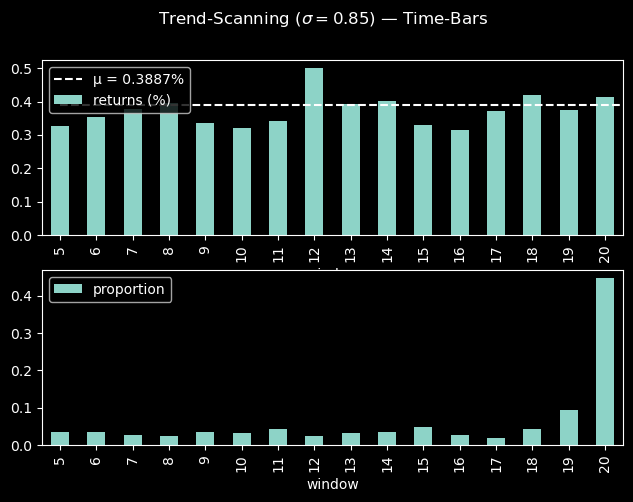

In [ ]:
# bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ret = bb_events_trend.ret
sr_bb_trend = ret.mean() / ret.std()
print(f"Trend-Scanning Meta-labels (σ = {volatility_threshold}):")
value_counts_data(bb_events_trend.bin, verbose=True)

events = bb_events_trend[bb_events_trend.bin == 1]
ret_by_window = events.groupby(['window'])["ret"].mean() * 100
ave_ret = events["ret"].mean() * 100
fig, ax = plt.subplots(2, 1, figsize=(7.5, 5), dpi=100)
ret_by_window.plot(kind="bar", label="returns (%)", ax=ax[0])
ax[0].hlines(ave_ret, xmin=0, xmax=bb_time_horizon, linestyles="--", label=f"μ = {ave_ret:.4f}%")
ax[0].legend()
events["window"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[1], legend=True)
fig.suptitle(fr"Trend-Scanning ($\sigma={volatility_threshold}$) — Time-Bars")
plt.subplots_adjust(top=0.88);

#### Random Forest

In [ ]:
dashes = "-" * 60
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

random_state = 52
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Strategy: Bollinger_w20_std1.5


##### Unweighted

2025-09-12 02:10:05 | INFO     | Samples are equally weighted.
2025-09-12 02:10:05 | INFO     | Training on 6,396 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1325
           1       0.52      1.00      0.68      1417

    accuracy                           0.52      2742
   macro avg       0.26      0.50      0.34      2742
weighted avg       0.27      0.52      0.35      2742


Confusion Matrix:
[[   0 1325]
 [   0 1417]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.49      0.48      1325
           1       0.51      0.49      0.50      1417

    accuracy      

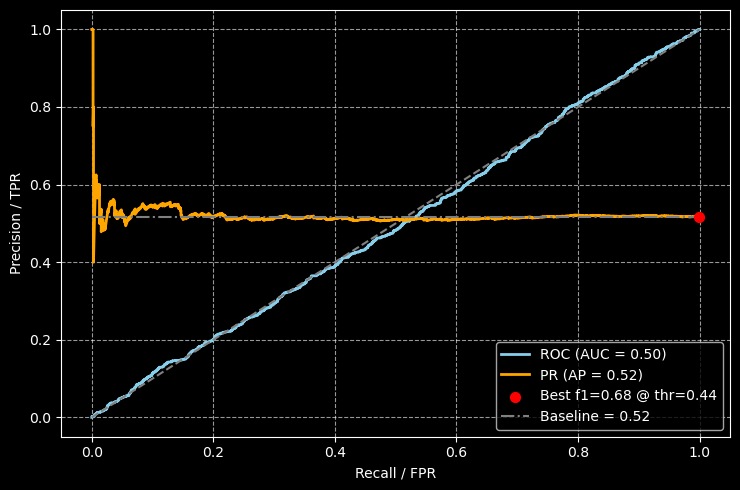

In [ ]:
model_bb_fh_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_fh_time)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_time, plot=True)

2025-09-12 02:10:40 | INFO     | Samples are equally weighted.
2025-09-12 02:10:41 | INFO     | Training on 6,398 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2172
           1       0.21      1.00      0.34       570

    accuracy                           0.21      2742
   macro avg       0.10      0.50      0.17      2742
weighted avg       0.04      0.21      0.07      2742


Confusion Matrix:
[[   0 2172]
 [   0  570]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.43      0.58      2172
           1       0.26      0.78      0.39       570

    accuracy          

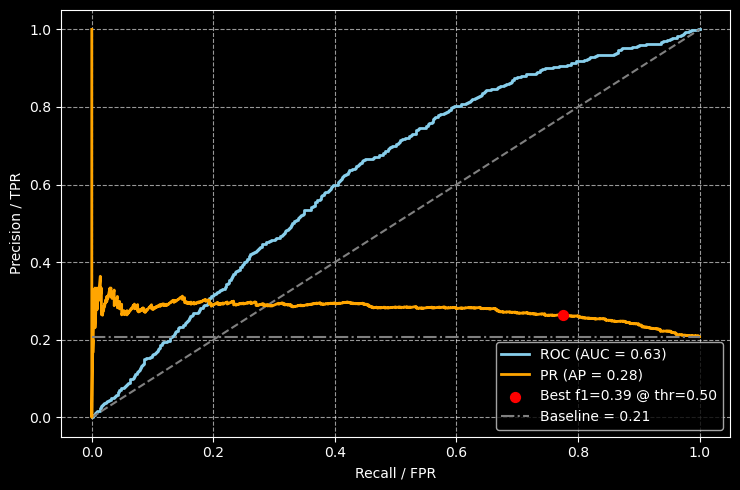

In [ ]:
model_bb_tbl_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_tbl_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_time, plot=True)

2025-09-12 02:14:58 | INFO     | Samples are equally weighted.
2025-09-12 02:14:58 | INFO     | Training on 6,398 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.85) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2691
           1       0.02      1.00      0.04        51

    accuracy                           0.02      2742
   macro avg       0.01      0.50      0.02      2742
weighted avg       0.00      0.02      0.00      2742


Confusion Matrix:
[[   0 2691]
 [   0   51]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      2691
           1       0.10      0.71      0.17        51

    accurac

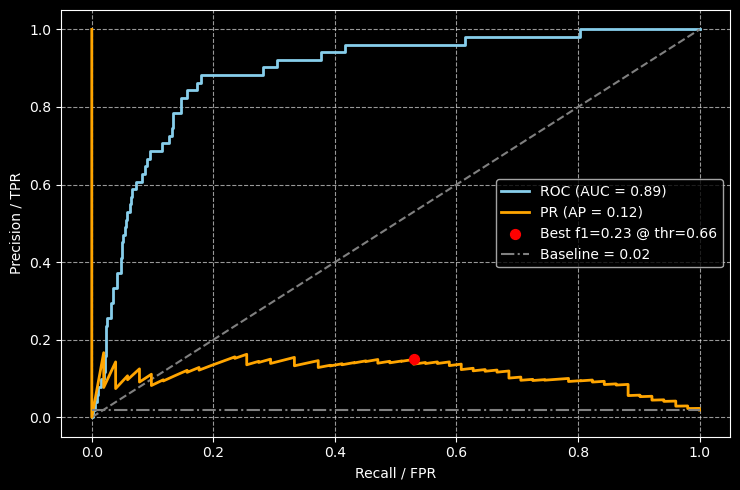

In [ ]:
model_bb_trend_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_time, plot=True)

##### Return-Weighted

2025-09-12 01:49:16 | INFO     | Training on 6,396 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1325
           1       0.52      1.00      0.68      1417

    accuracy                           0.52      2742
   macro avg       0.26      0.50      0.34      2742
weighted avg       0.27      0.52      0.35      2742


Confusion Matrix:
[[   0 1325]
 [   0 1417]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      1325
           1       0.00      0.00      0.00      1417

    accuracy                           0.48      2742
   macro avg       0.24    

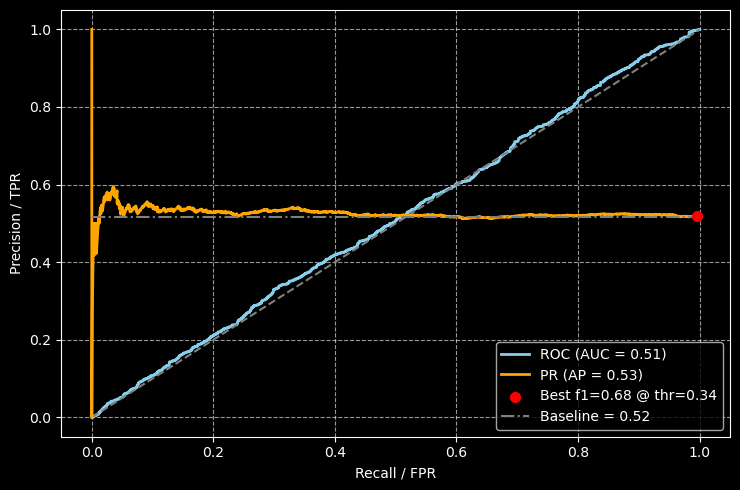

In [ ]:
model_bb_fh_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_fh_time, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_time_w, plot=True)

2025-09-12 01:49:36 | INFO     | Training on 6,398 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2371
           1       0.14      1.00      0.24       371

    accuracy                           0.14      2742
   macro avg       0.07      0.50      0.12      2742
weighted avg       0.02      0.14      0.03      2742


Confusion Matrix:
[[   0 2371]
 [   0  371]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.12      0.22      2371
           1       0.15      0.95      0.25       371

    accuracy                           0.24      2742
   macro avg       0.55      0.

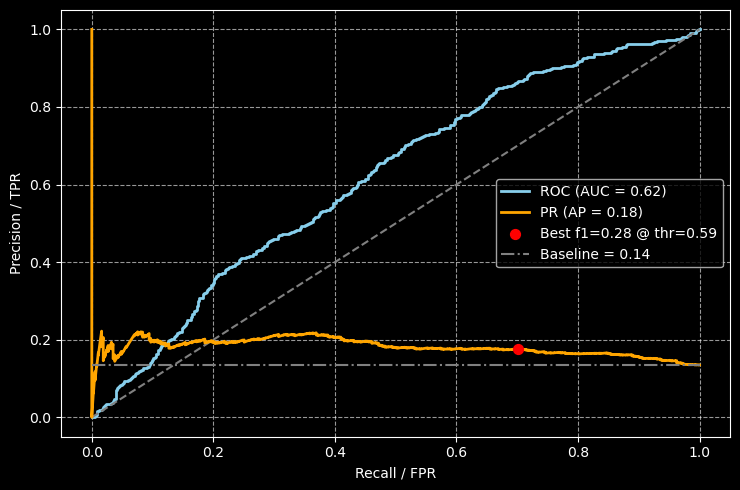

In [ ]:
model_bb_tbl_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_tbl_time, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_time_w, plot=True)

2025-09-12 01:49:56 | INFO     | Training on 6,398 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.1) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2404
           1       0.12      1.00      0.22       338

    accuracy                           0.12      2742
   macro avg       0.06      0.50      0.11      2742
weighted avg       0.02      0.12      0.03      2742


Confusion Matrix:
[[   0 2404]
 [   0  338]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.09      0.16      2404
           1       0.13      0.96      0.23       338

    accuracy                           0.20      2742
   macro avg       0.

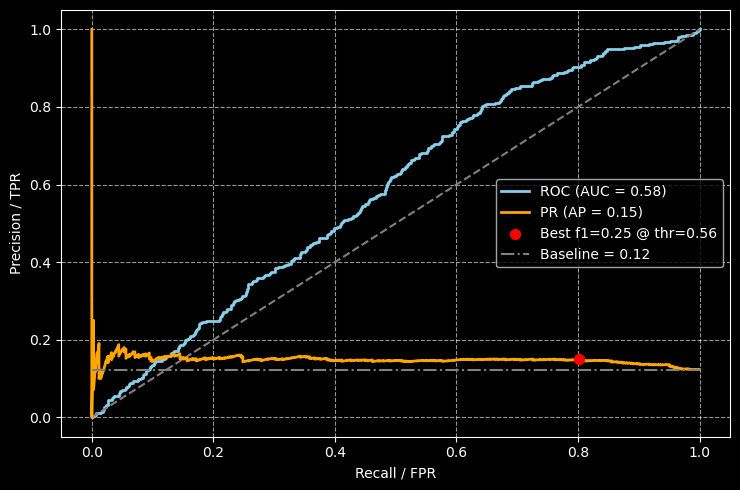

In [ ]:
model_bb_trend_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_time, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_time_w, plot=True)

##### Reports

In [ ]:
dirpath = Path("reports", "time_bars", bb_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

Strategy: Bollinger_w20_std1.5


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Simulated loop over labeling methods
labeling_methods = [
    "fixed-horizon", 
    "triple-barrier", 
    "trend-scanning", 
    ]
models = [model_bb_fh_time, model_bb_tbl_time, model_bb_trend_time]
report_frames = []
n = 3

for method, model in zip(labeling_methods[:n], models[:n]):
    # Replace with actual model predictions per method
    y_true = model.y_test.values
    y_pred = model.pred.values
    
    rpt = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(rpt).iloc[:3, :2].T  # shape: (metrics, classes)
    # print(df)
    
    # Add labeling method as top-level index
    df.index = pd.MultiIndex.from_product([[method], df.index], names=["method", "class"])
    report_frames.append(df)

# Concatenate all into one MultiIndex DataFrame
combined_df = pd.concat(report_frames)

print(combined_df)

# Step 1: Swap index levels so 'metric' is outermost
df_swapped = combined_df.swaplevel(0, 1).sort_index()

# Step 2: Stack columns to long format
long_df = df_swapped.stack()

# Step 3: Unstack labeling_method to compare across methods
comparison_df = long_df.unstack(level=1)

# Step 4: Optional — rename columns for clarity
comparison_df.columns = [f"{method}" for method in comparison_df.columns]

# Step 5: Reset index if needed
# comparison_df = comparison_df.reset_index()
print()
print(comparison_df.round(3))

# Step 6: Save as html
styled = (
    comparison_df.style
      .format("{:.3f}")  # 3 decimal places
      .set_table_styles([
          {"selector": "th", "props": [("text-align", "center"), ("background-color", "#f2f2f2")]},
          {"selector": "td", "props": [("text-align", "center")]}
      ])
      .highlight_max(axis=1, color="lightgreen")  # highlight best per row
)

styled.to_html("classification_comparison_styled.html")

                      precision    recall  f1-score
method         class                               
fixed-horizon  0       0.475565  0.492075  0.483680
               1       0.509117  0.492590  0.500717
triple-barrier 0       0.880262  0.433241  0.580685
               1       0.264196  0.775439  0.394115
trend-scanning 0       0.993679  0.876254  0.931280
               1       0.097561  0.705882  0.171429

                 fixed-horizon  trend-scanning  triple-barrier
class                                                         
0     precision          0.476           0.994           0.880
      recall             0.492           0.876           0.433
      f1-score           0.484           0.931           0.581
1     precision          0.509           0.098           0.264
      recall             0.493           0.706           0.775
      f1-score           0.501           0.171           0.394


In [ ]:
# fp = Path(dirpath, "unweighted")
# fp_plots = Path(dirpath, "plots", "unweighted")
# fp_plots.mkdir(parents=True, exist_ok=True)
# bb_models = [model_bb_fh_time, model_bb_tbl_time, model_bb_trend_time]

# bb_roc = compare_roc_curves(
#     bb_models[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc = compare_roc_curves(bb_models[:2], plot_titles[:2], columns=2)
# # bb_roc.savefig(dirpath / "bb_roc_barrier_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc_trend = compare_roc_curves(bb_models[2:], plot_titles[2:], columns=2)
# # bb_roc_trend.savefig(dirpath / "bb_roc_trend_comparison.png", bbox_inches="tight", dpi=100)

# # meta_labelling_classification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

In [ ]:
# fp_w = Path(dirpath, "return_weighted") 
# fp_plots = Path(dirpath, "plots", "return_weighted")
# fp_plots.mkdir(parents=True, exist_ok=True)

# bb_models_w = [model_bb_fh_time_w, model_bb_tbl_time_w, model_bb_trend_time_w]
# bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
# filenames_w = [f"{w}_w" for w in filenames]

# bbb_roc = compare_roc_curves(
#     bb_models_w[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# meta_labelling_classification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

In [ ]:
# fp_tw = Path(dirpath, "time_weighted") 
# plot_titles_tw = [fr"$\lambda = {decay}$" for decay in time_decays]
# columns = 2
# height = 7.5
# fig_titles = [f"Time-Decay ($\lambda$): {method} ROC Curves" for method in bb_titles]

# bb_models_tw, bb_titles_tw, filenames_tw = [], [], []
# for time_decay, labels in models_bb_time_tw.items():
#     for i, (label, model) in enumerate(labels.items()):
#         bb_models_tw.append(model)
#         bb_titles_tw.append(f"Time-Weighted (λ = {time_decay}) {bb_titles[i]}")
#         filenames_tw.append(f"{filenames[i]}_tw_{time_decay}")

# meta_labelling_classification_reports(model_data=bb_models_tw, titles=bb_titles_tw, output_filenames=filenames_tw, path=fp_tw)

# fig_title = fig_titles[0]
# bb_roc_fh_tw = compare_roc_curves(bb_models_tw[::4], plot_titles_tw, fig_title, columns, height)
# bb_roc_fh_tw.savefig(dirpath / "bb_roc_fixed_horizon_comparison_time_weighted.png", bbox_inches="tight", dpi=100)

##### Out-of-Sample

In [ ]:
model_preds_time = {}
time_metrics_oos = {}
df = bb_time_bars[sample_end:]

# Create feature set for model
X_test = bb_feat_time[sample_end:].join(bb_side[bb_side != 0]).dropna()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71170 entries, 2021-12-31 00:05:00 to 2024-12-31 00:00:00
Data columns (total 52 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             71170 non-null  float32
 1   spread            71170 non-null  float32
 2   bb_lower          71170 non-null  float32
 3   bb_upper          71170 non-null  float32
 4   bb_bandwidth      71170 non-null  float32
 5   bb_percentage     71170 non-null  float64
 6   ret               71170 non-null  float32
 7   ret_5             71170 non-null  float32
 8   ret_10            71170 non-null  float32
 9   ret_1_lag_1       71170 non-null  float32
 10  ret_5_lag_1       71170 non-null  float32
 11  ret_10_lag_1      71170 non-null  float32
 12  ret_1_lag_2       71170 non-null  float32
 13  ret_5_lag_2       71170 non-null  float32
 14  ret_10_lag_2      71170 non-null  float32
 15  ret_1_lag_3       71170 non-null  float32
 16  ret_5

In [ ]:
fit = model_bb_fh_time.fit
prob = fit.predict_proba(X_test)[:, 1]

bb_fh_time_results = run_meta_labeling_analysis(
    df=bb_time_bars,
    signals=bb_side.loc[sample_end:],
    meta_probabilities=prob,
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name()
    )
bb_fh_time_results.keys()

In [ ]:
# threshold = 0.5
# for i, events in enumerate(model_preds_time.values()):
#     meta_events = events[events.prob > threshold]
#     metrics = calculate_performance_metrics(
#         returns=meta_events["ret"],
#         data_index=X_test.index,
#         positions=meta_events["side"],
#     )
#     time_metrics_oos[filenames[i].replace(f"{name}_", "")] = metrics
#     print(f"{bb_titles[i]} done.")
#     # break
    
# time_metrics_oos_df = pd.DataFrame(time_metrics_oos)
# time_metrics_oos_df

Fixed-Time Horizon done.
Triple-Barrier done.
Trend-Scanning (σ = 0.1) done.
Trend-Scanning (σ = 0.85) done.


,fixed_horizon,triple_barrier,trend_scanning_0.1,trend_scanning_0.85
total_return,1.326825,0.293271,1.566851,0.17845
annualized_return,0.325033,0.089485,0.369102,0.056246
volatility,0.518462,0.36281,0.504051,0.646608
downside_volatility,0.391318,0.159045,0.387323,0.487371
sharpe_ratio,6.286665,5.809964,7.171452,5.759358
sortino_ratio,8.329264,13.253568,9.332731,7.6411
var_95,-0.002752,-0.001637,-0.002704,-0.00374
cvar_95,-0.004501,-0.002161,-0.004408,-0.005766
skewness,-0.139889,0.60824,-0.232854,-0.089229
kurtosis,8.203582,0.730403,8.134464,5.695448


In [ ]:
# # bb_models_tw = [model_bb_fh_time_tw, model_bb_tbl_time_tw, model_bb_trend_time_tw_tw]
# model_preds_time_tw = {}
# time_metrics_oos_tw = {}
# X = bb_feat_time_oos[bb_feat_time_oos["side"] != 0]

# for i, model in enumerate(bb_models_tw):
#     df, metrics = backtest_model(model.fit, X, bb_df_oos_time.close)
#     model_preds_time_tw[bb_titles[i]] = df
#     time_metrics_oos_tw[filenames[i]] = metrics
#     print(f"{bb_titles[i]} done.")

# time_metrics_oos_df_tw = pd.DataFrame(time_metrics_oos_tw)
# time_metrics_oos_df_tw

### Tick-Bars

In [ ]:
bb_df = bb_tick_bars.loc[sample_start : sample_end]
bb_side = bb_strategy.generate_signals(bb_tick_bars)
close = bb_df.close

# Volatility target for barriers
vol_target = get_daily_vol(close, lookback=bb_period) * bb_vol_multiplier
thres = vol_target.mean()
print(f"CUSUM filter threshold: {thres:.4%}")

t_events = cusum_filter(close, thres)
t_events = t_events.intersection(bb_side[bb_side != 0].index)
print(f"t_events: {t_events.size:,}")

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(bb_timeframe) if x.isnumeric()))
bb_tick_horizon = bb_time_horizon * tm
if bb_timeframe.startswith("H"):
    bb_tick_horizon *= 60
elif bb_timeframe.startswith("D"):
    bb_tick_horizon *= 60 * 24

h = timedelta(minutes=bb_tick_horizon)
print(f"Time Horizon: {h}")
vertical_barriers_bars = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)
vertical_barriers_time = add_vertical_barrier(t_events, close, minutes=bb_tick_horizon)

CUSUM filter threshold: 0.1136%
2025-09-11 21:24:27 | INFO     | 17,596 CUSUM-filtered events
t_events: 14,955
Time Horizon: 4:10:00


#### Feature Engineering

In [ ]:
# No shifting b/c mean-reversion seems to benefit from contemporaneous information
bb_feat = create_bollinger_features(bb_tick_bars, bb_lookback, bb_period, bb_std)
bb_feat.info()

bb_feat_tick = bb_feat.copy()
# not_stationary = is_stationary(bb_feat_tick.dropna())

2025-09-11 21:24:47 | INFO     | d = 0.0645 makes close (log-transformed) stationary for ADF test (α=0.05). ρ(y, y_fracdiff) = 0.9992
2025-09-11 21:25:06 | INFO     | d = 0.0977 makes bb_lower (log-transformed) stationary for ADF test (α=0.05). ρ(y, y_fracdiff) = 0.9988
2025-09-11 21:25:21 | INFO     | d = 0.0635 makes bb_upper (log-transformed) stationary for ADF test (α=0.05). ρ(y, y_fracdiff) = 0.9992
2025-09-11 21:25:38 | INFO     | 
Dropped features with correlation > 0.8: 
	['sma_diff_10_200', 'sma_diff_10_50', 'sma_diff_20_100', 'sma_diff_20_200', 'sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_50_200', 'sma_diff_5_100', 'sma_diff_5_20', 'sma_diff_5_200', 'sma_diff_5_50']
Kept features: 
	['sma_diff_5_10', 'sma_diff_10_20', 'sma_diff_10_100', 'sma_diff_100_200']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 871900 entries, 2018-01-01 23:53:43.270001 to 2024-12-30 23:57:20.455001
Data columns (total 51 columns):
 #   Column            Non-Null Count   Dtype  
---  ------   

#### Fixed-Time Horizon Method

In [ ]:
bb_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_bars,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
print(f"Fixed-Time Horizon (h={bb_time_horizon}):")
value_counts_data(bb_events_fh.bin, verbose=True)

bb_events_fh_tick = bb_events_fh.copy()

ret = bb_events_fh.ret
sr_bb_fh = ret.mean() / ret.std()
av_uniqueness = bb_events_fh['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

Fixed-Time Horizon (h=50):

     count  proportion
bin                   
1    7,646    0.511746
0    7,295    0.488254


Average Uniqueness: 0.5136


In [ ]:
bb_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_time,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
print(f"Fixed-Time Horizon (h={h}):")
value_counts_data(bb_events_fh.bin, verbose=True)

bb_events_fh_tick1 = bb_events_fh.copy()

ret = bb_events_fh.ret
sr_bb_fh = ret.mean() / ret.std()
av_uniqueness = bb_events_fh['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

Fixed-Time Horizon (h=4:10:00):

     count  proportion
bin                   
1    7,690    0.514657
0    7,252    0.485343


Average Uniqueness: 0.3125


#### Triple-Barrier Method

In [ ]:
bb_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_bars,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tbl = get_event_weights(bb_events_tbl, close)
bb_events_tbl_tick = bb_events_tbl.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tbl.bin, verbose=True)


ret = bb_events_tbl.ret
sr_bb_tbl = ret.mean() / ret.std()
av_uniqueness = bb_events_tbl['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h=50):

     count  proportion
bin                   
0    9,315    0.623452
1    5,626    0.376548


Average Uniqueness: 0.6536


In [ ]:
bb_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_time,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tbl = get_event_weights(bb_events_tbl, close)
bb_events_tbl_tick1 = bb_events_tbl.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={h}):")
value_counts_data(bb_events_tbl.bin, verbose=True)


ret = bb_events_tbl.ret
sr_bb_tbl = ret.mean() / ret.std()
av_uniqueness = bb_events_tbl['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h=4:10:00):

     count  proportion
bin                   
0    7,959     0.53266
1    6,983     0.46734


Average Uniqueness: 0.5227


#### Trend-Scanning Method

In [ ]:
span = (5, bb_time_horizon + 1)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85
side = bb_side.reindex(close.index)

Bollinger_w20_std1.5:
bb_events_trend.shape: (14954, 8)

trend_scanning_meta_labels 0.1: 
     count  proportion
bin                   
0    7,502    0.501672
1    7,452    0.498328



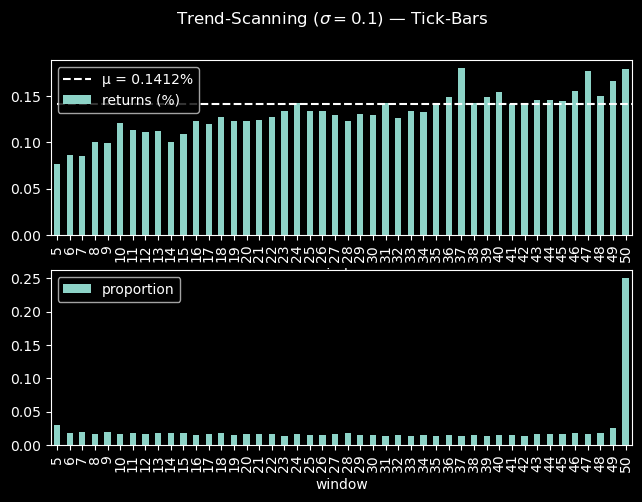

In [ ]:
bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
bb_events_trend_tick = bb_events_trend.copy()
ret = bb_events_trend.ret
sr_bb_trend = ret.mean() / ret.std()


print(f"Bollinger_w{bb_period}_std{bb_std}:")
print(f"bb_events_trend.shape: {bb_events_trend.shape}\n")

print(f"trend_scanning_meta_labels {volatility_threshold}: \n{value_counts_data(bb_events_trend.bin)}\n")

events = bb_events_trend[bb_events_trend.bin == 1]
ret_by_window = events.groupby(['window'])["ret"].mean() * 100
ave_ret = events["ret"].mean() * 100
fig, ax = plt.subplots(2, 1, figsize=(7.5, 5), dpi=100)
ret_by_window.plot(kind="bar", label="returns (%)", ax=ax[0])
ax[0].hlines(ave_ret, xmin=0, xmax=bb_time_horizon, linestyles="--", label=f"μ = {ave_ret:.4f}%")
ax[0].legend()
events["window"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[1], legend=True)
fig.suptitle(fr"Trend-Scanning ($\sigma={volatility_threshold}$) — Tick-Bars")
plt.subplots_adjust(top=0.88);

#### Random Forest

In [ ]:
dashes = "-" * 60
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

random_state = 52
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

##### Unweighted

2025-09-10 06:25:19 | INFO     | Samples are equally weighted.
2025-09-10 06:25:19 | INFO     | Training on 10,335 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2359
           1       0.47      1.00      0.64      2070

    accuracy                           0.47      4429
   macro avg       0.23      0.50      0.32      4429
weighted avg       0.22      0.47      0.30      4429


Confusion Matrix:
[[   0 2359]
 [   0 2070]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.28      0.41      2359
           1       0.52      0.89      0.66      2070

    accuracy     

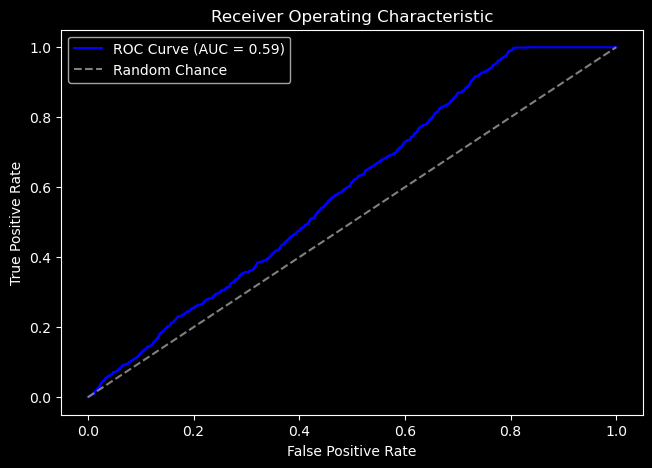

In [ ]:
model_bb_fh_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_fh_tick)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_tick, plot=True)

2025-09-10 06:25:52 | INFO     | Samples are equally weighted.
2025-09-10 06:25:53 | INFO     | Training on 10,335 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2715
           1       0.39      1.00      0.56      1714

    accuracy                           0.39      4429
   macro avg       0.19      0.50      0.28      4429
weighted avg       0.15      0.39      0.22      4429


Confusion Matrix:
[[   0 2715]
 [   0 1714]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.48      0.60      2715
           1       0.50      0.81      0.62      1714

    accuracy         

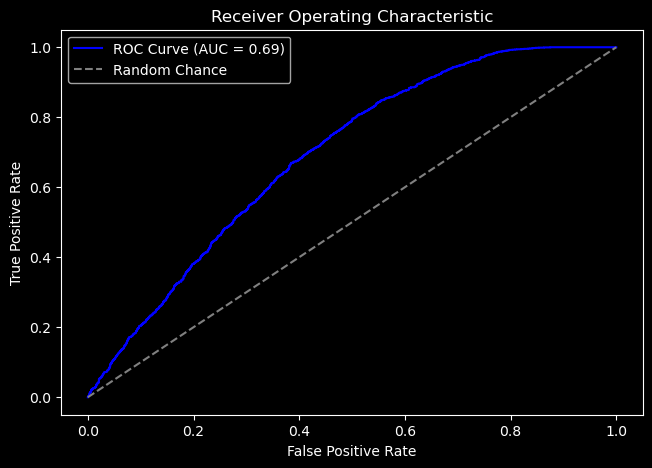

In [ ]:
model_bb_tbl_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_tbl_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_tick, plot=True)

In [ ]:
model_bb_trend_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_tick, plot=True)

2025-09-03 22:58:11.321 | INFO     | notebooks.training:train_meta_model:64 - Samples are equally weighted.
2025-09-03 22:58:11.408 | INFO     | notebooks.training:train_meta_model:90 - Training on 10,337 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.1) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2379
           1       0.46      1.00      0.63      2050

    accuracy                           0.46      4429
   macro avg       0.23      0.50      0.32      4429
weighted avg       0.21      0.46      0.29      4429


Confusion Matrix:
[[   0 2379]
 [   0 2050]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0

In [ ]:
model_bb_trend_mr_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_mr_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_mr_tick, plot=True)

2025-09-03 22:58:34.565 | INFO     | notebooks.training:train_meta_model:64 - Samples are equally weighted.
2025-09-03 22:58:34.806 | INFO     | notebooks.training:train_meta_model:90 - Training on 10,337 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.85) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4129
           1       0.07      1.00      0.13       300

    accuracy                           0.07      4429
   macro avg       0.03      0.50      0.06      4429
weighted avg       0.00      0.07      0.01      4429


Confusion Matrix:
[[   0 4129]
 [   0  300]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      

##### Return-Weighted

2025-09-10 04:41:47 | INFO     | Training on 10,335 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2359
           1       0.47      1.00      0.64      2070

    accuracy                           0.47      4429
   macro avg       0.23      0.50      0.32      4429
weighted avg       0.22      0.47      0.30      4429


Confusion Matrix:
[[   0 2359]
 [   0 2070]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.96      0.69      2359
           1       0.51      0.05      0.09      2070

    accuracy                           0.53      4429
   macro avg       0.52   

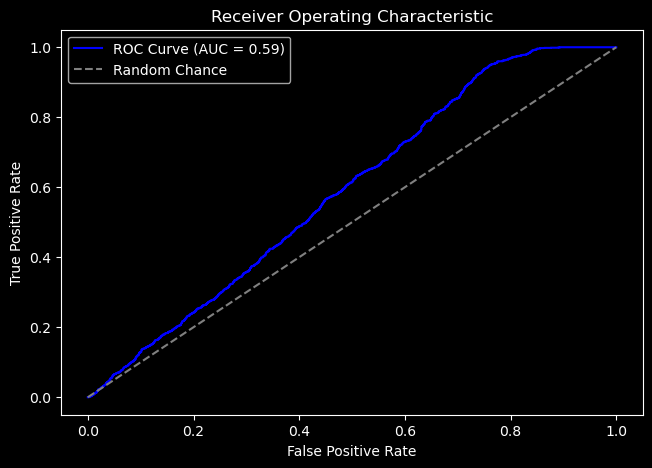

In [ ]:
model_bb_fh_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_fh_tick, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_tick_w, plot=True)

2025-09-10 04:42:20 | INFO     | Training on 10,335 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3785
           1       0.15      1.00      0.25       644

    accuracy                           0.15      4429
   macro avg       0.07      0.50      0.13      4429
weighted avg       0.02      0.15      0.04      4429


Confusion Matrix:
[[   0 3785]
 [   0  644]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.26      0.41      3785
           1       0.18      0.95      0.30       644

    accuracy                           0.36      4429
   macro avg       0.57      0

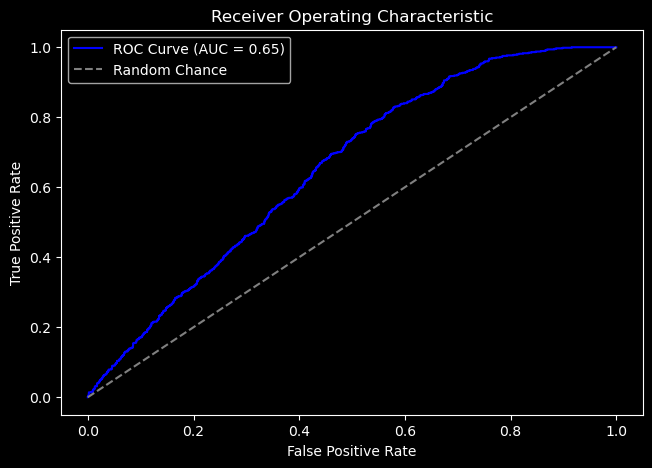

In [ ]:
model_bb_tbl_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_tbl_tick, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_tick_w, plot=True)

In [ ]:
model_bb_trend_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_tick, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_tick_w, plot=True)

2025-09-03 22:59:59.663 | INFO     | notebooks.training:train_meta_model:49 - Samples weighted by t-value.
2025-09-03 22:59:59.839 | INFO     | notebooks.training:train_meta_model:90 - Training on 10,337 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.1) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2379
           1       0.46      1.00      0.63      2050

    accuracy                           0.46      4429
   macro avg       0.23      0.50      0.32      4429
weighted avg       0.21      0.46      0.29      4429


Confusion Matrix:
[[   0 2379]
 [   0 2050]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.

In [ ]:
model_bb_trend_mr_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_mr_tick, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_mr_tick_w, plot=True)

2025-09-03 23:00:29.326 | INFO     | notebooks.training:train_meta_model:49 - Samples weighted by t-value.
2025-09-03 23:00:29.573 | INFO     | notebooks.training:train_meta_model:90 - Training on 10,337 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.85) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4129
           1       0.07      1.00      0.13       300

    accuracy                           0.07      4429
   macro avg       0.03      0.50      0.06      4429
weighted avg       0.00      0.07      0.01      4429


Confusion Matrix:
[[   0 4129]
 [   0  300]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0

##### Reports

In [ ]:
dirpath = Path("reports", "tick_bars", f"tick-{bb_tick_bars.tick_volume.iloc[0]}")
dirpath.mkdir(parents=True, exist_ok=True)

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

Strategy: Bollinger_w20_std1.5


In [ ]:
bb_models = [model_bb_fh_tick, model_bb_tbl_tick, model_bb_trend_tick, model_bb_trend_mr_tick]
fp = Path(dirpath, "unweighted") 
fp.mkdir(parents=True, exist_ok=True)

fp_plots = Path(dirpath, "plots", "unweighted")
fp_plots.mkdir(parents=True, exist_ok=True)

bb_roc = compare_roc_curves(
    bb_models[:], plot_titles[:], columns=2, height=7.5, 
    fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
    )
bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)


meta_labelling_classification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

NameError: name 'model_bb_fh_tick' is not defined

2025-09-03 21:50:29.717 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\return_weighted\bb_w20_std1.5_fixed_horizon_w_primary_clf_report.png'
2025-09-03 21:50:29.852 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\return_weighted\bb_w20_std1.5_fixed_horizon_w_meta_clf_report.png'
2025-09-03 21:50:29.957 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\return_weighted\bb_w20_std1.5_triple_barrier_w_primary_clf_report.png'
2025-09-03 21:50:30.050 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\return_weighted\bb_w20_std1.5_triple_barrier_w_meta_clf_report.png'
2025-09-03 21:50:30.184 | INFO     | afml.backtest_s

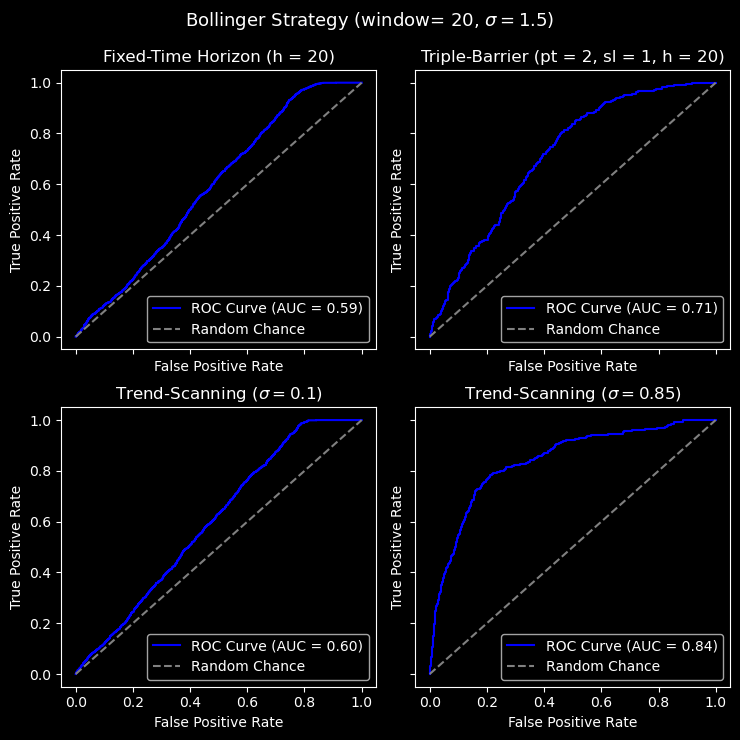

In [ ]:
fp_w = Path(dirpath, "return_weighted") 
bb_models_w = [model_bb_fh_tick_w, model_bb_tbl_tick_w, model_bb_trend_tick_w, model_bb_trend_mr_tick_w]
bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
filenames_w = [f"{w}_w" for w in filenames]

fp_plots = Path(dirpath, "plots", "return_weighted")
fp_plots.mkdir(parents=True, exist_ok=True)

bb_roc_w = compare_roc_curves(bb_models_w[:], plot_titles[:], columns=2, height=7.5, fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)")
bb_roc_w.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

meta_labelling_classification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

##### Out-of-Sample

In [ ]:
bb_models_w = [model_bb_fh_tick_w, model_bb_tbl_tick_w, model_bb_trend_tick_w, model_bb_trend_mr_tick_w]
model_preds_tick_w = {}
tick_metrics_oos_w = {}
X = bb_feat_tick.loc[sample_end:]
df_oos = bb_tick_bars.loc[sample_end:]

for i, model in enumerate(bb_models_w):
    df, metrics = backtest_model(model.fit, X, df_oos.close)
    model_preds_tick_w[bb_titles[i]] = df
    tick_metrics_oos_w[filenames[i]] = metrics
    print(f"{bb_titles[i]} done.")

tick_metrics_oos_df_w = pd.DataFrame(tick_metrics_oos_w)
tick_metrics_oos_df_w

,bb_w20_std1.5_fixed_horizon,bb_w20_std1.5_triple_barrier,bb_w20_std1.5_trend_scanning_0.1,bb_w20_std1.5_trend_scanning_0.85
total_return,0.160763,0.047866,0.207899,0.162994
annualized_return,0.051175,0.015776,0.065277,0.051851
volatility,0.036918,0.024786,0.036585,0.032053
downside_volatility,0.059282,0.066746,0.064249,0.085376
sharpe_ratio,1.369229,0.643406,1.745309,1.591682
sortino_ratio,0.852697,0.238927,0.993822,0.597568
var_95,-0.000114,0.0,-0.000097,0.0
cvar_95,-0.000252,-0.000006,-0.000245,-0.000008
skewness,-0.466475,0.659224,-1.007724,-1.785344
kurtosis,121.158862,273.041207,144.159781,182.726129


#### Time- vs. Tick-Bars

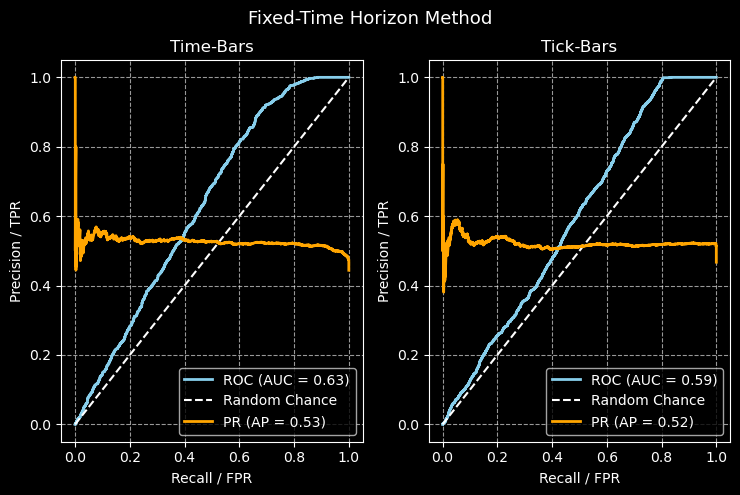

In [ ]:
titles = ["Time-Bars", "Tick-Bars"]
title = "Fixed-Time Horizon Method"
roc_pr = compare_roc_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

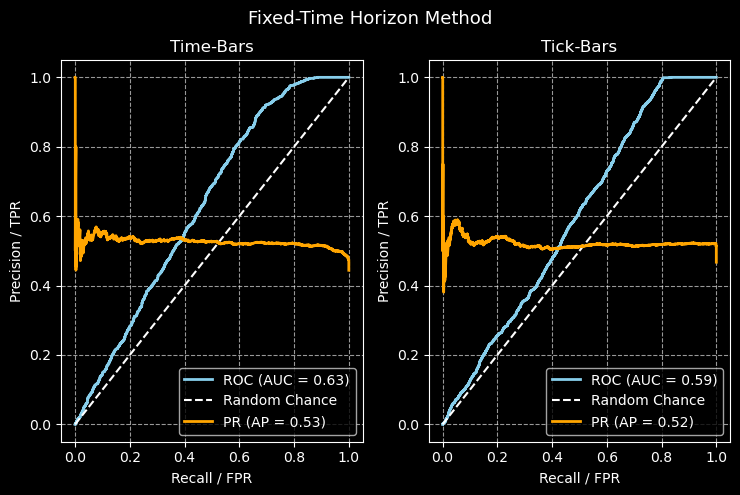

In [ ]:
titles = ["Time-Bars", "Tick-Bars"]
title = "Fixed-Time Horizon Method"
roc_pr = compare_roc_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

Reloading 'afml.backtest_statistics.reporting'.


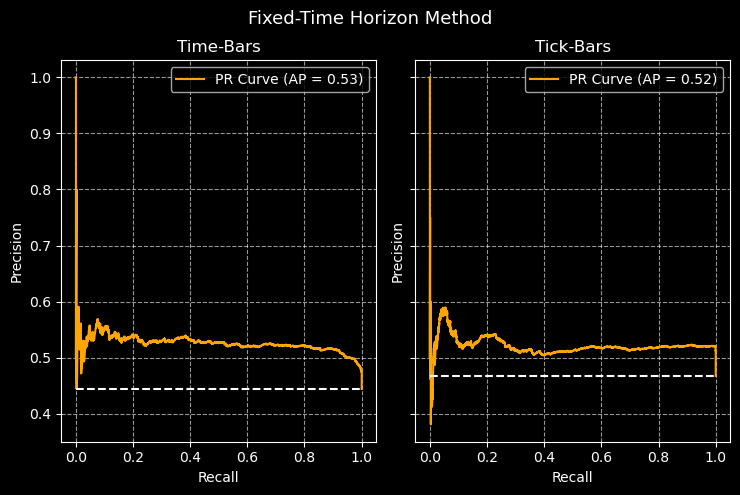

In [ ]:
pr = compare_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

,ROC AUC,AP,Default Threshold,Default Precision,Default Recall,Default F1,Tuned Threshold,Tuned Precision,Tuned Recall,Tuned F1
Model,,,,,,,,,,
Fixed-Time Horizon,0.63,0.53,0.5,0.51,0.86,0.64,0.40,0.50,0.98,0.66
Triple-Barrier,0.72,0.50,0.5,0.44,0.81,0.57,0.53,0.48,0.73,0.58


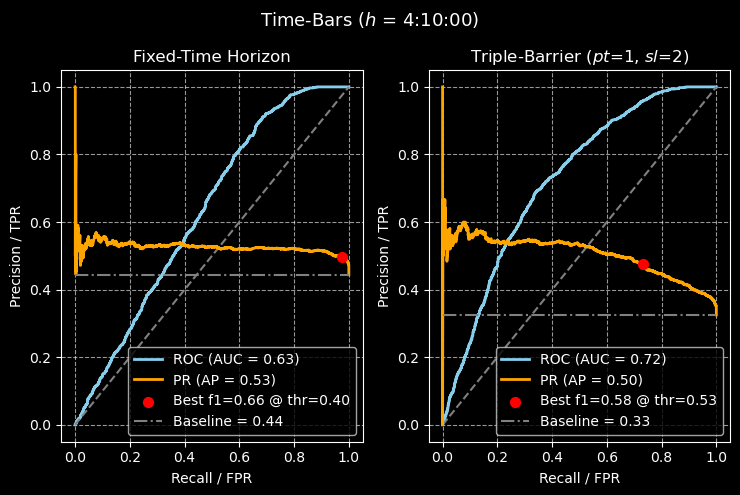

In [ ]:
model_names = ["Fixed-Time Horizon", "Triple-Barrier"]
titles = [
    f"Fixed-Time Horizon", 
    fr"Triple-Barrier ($\mathit{{pt}}$={bb_pt_barrier}, "
    fr"$\mathit{{sl}}$={bb_sl_barrier})",
    ]
title = fr"Time-Bars ($\mathit{{h}}$ = {timedelta(minutes=bb_tick_horizon)})"
model_data_list = [model_bb_fh_time, model_bb_tbl_time] #, model_bb_tbl_tick, model_bb_tbl_tick_w]
metric = "f1"
n = 3

fig, summary_df = compare_roc_pr_curves(
    model_data=model_data_list[:n],
    model_names=model_names[:n],
    titles=titles[:n],
    fig_title=title,
    columns=2,
    metric=metric,
    height=5,
    show_baseline=True
)

summary_df
# summary_df.to_html("roc_pr_dual_metrics.html", float_format="%.3f")

,ROC AUC,AP,Default Threshold,Default Precision,Default Recall,Default F1,Tuned Threshold,Tuned Precision,Tuned Recall,Tuned F1
Model,,,,,,,,,,
Fixed-Time Horizon,0.59,0.52,0.5,0.52,0.89,0.66,0.38,0.52,1.00,0.68
Triple-Barrier,0.69,0.53,0.5,0.50,0.81,0.62,0.49,0.49,0.85,0.62


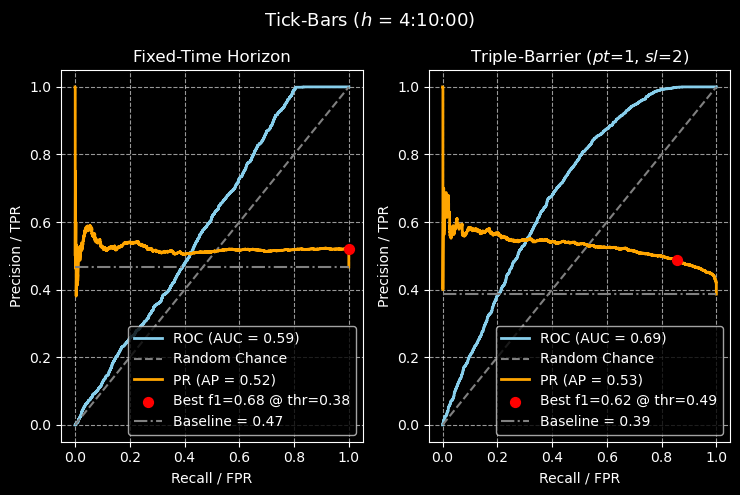

In [ ]:
model_names = ["Fixed-Time Horizon", "Triple-Barrier"]
titles = [
    f"Fixed-Time Horizon", 
    fr"Triple-Barrier ($\mathit{{pt}}$={bb_pt_barrier}, "
    fr"$\mathit{{sl}}$={bb_sl_barrier})",
    ]
title = fr"Tick-Bars ($\mathit{{h}}$ = {timedelta(minutes=bb_tick_horizon)})"
model_data_list = [model_bb_fh_tick, model_bb_tbl_tick] #, model_bb_tbl_tick, model_bb_tbl_tick_w]
n = 3

fig, summary_df = compare_roc_pr_curves(
    model_data=model_data_list[:n],
    model_names=model_names[:n],
    titles=titles[:n],
    fig_title=title,
    columns=2,
    metric=metric,
    height=5,
    show_baseline=True
)

summary_df.round(2)
# summary_df.to_html("roc_pr_dual_metrics.html", float_format="%.3f")

## 3. Moving Average Crossover Strategy

In [ ]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

ma_timeframe = "M30"
tick_bar_size = tick_bar_dict.get(ma_timeframe)
ma_time_bars, ma_tick_bars = get_data(symbol, ma_timeframe)
ma_bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"

fast_window, slow_window = 20, 50
ma_strategy = MACrossoverStrategy(fast_window, slow_window)
ma_pt_barrier, ma_sl_barrier, ma_time_horizon = (4, 1.5, 100)
ma_vol_multiplier = 0.3
time_decay = 0.3
linear_decay = False

Loaded EURUSD_M30_tick-1000_2018-01-01-2024-12-31.parq
Loaded EURUSD_M30_time_2018-01-01-2024-12-31.parq


### Time-Bars

In [ ]:
ma_df = ma_time_bars.loc[sample_start : sample_end]
close = ma_df.close
vol_target = get_daily_vol(close, lookback=fast_window).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

ma_side = ma_strategy.generate_signals(ma_df)
vertical_barriers = add_vertical_barrier(t_events, close, num_bars=ma_time_horizon)

CUSUM filter threshold: 0.0478%, t_events: 18,373


#### Feature Engineering

In [ ]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_df)
ma_feat_time = ma_feat.copy()
ma_feat.info()

Reloading 'afml.strategies.ma_crossover_feature_engine'.
Memory usage reduced from 27.33 MB to 13.74 MB (49.7% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49280 entries, 2018-01-01 23:30:00 to 2021-12-31 23:00:00
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           49280 non-null  float32
 1   ma_20                           49280 non-null  float32
 2   ma_50                           49280 non-null  float32
 3   ma_100                          49280 non-null  float32
 4   ma_200                          49280 non-null  float32
 5   ma_10_20_cross                  49280 non-null  int8   
 6   ma_20_50_cross                  49280 non-null  int8   
 7   ma_50_200_cross                 49280 non-null  int8   
 8   ma_spread_10_20                 49280 non-null  float32
 9   ma_spread_20_50                 49280 non-null  float32
 1

#### Fixed-Time Horizon Method

In [ ]:
ma_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_fh = get_event_weights(ma_events_fh, close)
ma_events_fh_time = ma_events_fh.copy()
ma_events_fh.info()
ret = ma_events_fh.ret
sr_ma_fh = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_fh:.4f}")

#### Triple-Barrier Method

In [ ]:
ma_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_tbl = get_event_weights(ma_events_tbl, close)
ma_events_tbl_time = ma_events_tbl.copy()
ma_events_tbl.info()
ret = ma_events_tbl.ret
sr_ma_tbl = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_tbl:.4f}")

In [ ]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    })
ma_metrics_df

#### Trend-Scanning Method

In [ ]:
span = (5, ma_time_horizon)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

close = ma_df.close
vol_target = get_daily_vol(close, lookback=100).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

side = ma_strategy.generate_signals(ma_df)

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_time = ma_events_trend.copy()
ret = ma_events_trend.ret
sr_ma_trend = ret.mean() / ret.std()

ma_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
ma_events_trend_mr_time = ma_events_trend_mr.copy()
ret = ma_events_trend.ret_mr
sr_ma_trend_mr = ret.mean() / ret.std()

# ma_events_trend_metrics_mr = calculate_label_metrics(ma_df.index, side, ma_events_trend_mr)

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    "trend_scanning": sr_ma_trend,
    "trend_scanning_mr": sr_ma_trend_mr,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

### Tick-Bars

In [ ]:
ma_df = ma_tick_bars.loc[sample_start : sample_end]
close = ma_df.close
vol_target = get_daily_vol(close, lookback=100) # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")
ma_side = ma_strategy.generate_signals(ma_df)

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(ma_timeframe) if x.isnumeric()))
ma_tick_horizon = ma_time_horizon * tm
if ma_timeframe.startswith("H"):
    ma_tick_horizon *= 60
elif ma_timeframe.startswith("D"):
    ma_tick_horizon *= 60 * 24

print(f"Time Horizon: {pd.Timedelta(minutes=tm)}")
vertical_barriers = add_vertical_barrier(t_events, close, minutes=ma_tick_horizon)

#### Feature Engineering

In [ ]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_df)
ma_feat_tick = ma_feat.copy()
ma_feat.info()

Reloading 'afml.strategies.ma_crossover_feature_engine'.
Memory usage reduced from 27.33 MB to 13.74 MB (49.7% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49280 entries, 2018-01-01 23:30:00 to 2021-12-31 23:00:00
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           49280 non-null  float32
 1   ma_20                           49280 non-null  float32
 2   ma_50                           49280 non-null  float32
 3   ma_100                          49280 non-null  float32
 4   ma_200                          49280 non-null  float32
 5   ma_10_20_cross                  49280 non-null  int8   
 6   ma_20_50_cross                  49280 non-null  int8   
 7   ma_50_200_cross                 49280 non-null  int8   
 8   ma_spread_10_20                 49280 non-null  float32
 9   ma_spread_20_50                 49280 non-null  float32
 1

#### Fixed-Time Horizon Method

In [ ]:
ma_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_fh = get_event_weights(ma_events_fh, close)
ma_events_fh_tick = ma_events_fh.copy()
ma_events_fh.info()
ret = ma_events_fh.ret
sr_ma_fh = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_fh:.4f}")

#### Triple-Barrier Method

In [ ]:
ma_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_tbl = get_event_weights(ma_events_tbl, close)
ma_events_tbl_tick = ma_events_tbl.copy()
ma_events_tbl.info()
ret = ma_events_tbl.ret
sr_ma_tbl = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_tbl:.4f}")

In [ ]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    })
ma_metrics_df

#### Trend-Scanning Method

In [ ]:
span = (5, ma_time_horizon)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

vol_target = get_daily_vol(close, lookback=100).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

side = ma_strategy.generate_signals(ma_df)

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_tick = ma_events_trend.copy()
ret = ma_events_trend.ret
sr_ma_trend = ret.mean() / ret.std()

ma_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
ma_events_trend_mr_tick = ma_events_trend_mr.copy()
ret = ma_events_trend.ret_mr
sr_ma_trend_mr = ret.mean() / ret.std()

# ma_events_trend_metrics_mr = calculate_label_metrics(ma_df.index, side, ma_events_trend_mr)

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    "trend_scanning": sr_ma_trend,
    "trend_scanning_mr": sr_ma_trend_mr,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

### Random Forest

In [ ]:
random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )
time_decay = 0.3

##### Time-Bars

In [ ]:
model_ma_fh_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_fh_time)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(
    model_ma_fh_time.y_test, model_ma_fh_time.w_test, model_ma_fh_time.pred, model_ma_fh_time.prob, plot=True
    )

In [ ]:
model_ma_tbl_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_tbl_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(
    model_ma_tbl_time.y_test, model_ma_tbl_time.w_test, model_ma_tbl_time.pred, model_ma_tbl_time.prob, plot=True
    )

In [ ]:
model_ma_trend_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_trend_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(
    model_ma_trend_time.y_test, model_ma_trend_time.w_test, model_ma_trend_time.pred, model_ma_trend_time.prob, plot=True
    )

In [ ]:
model_ma_trend_mr_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_trend_mr_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(
    model_ma_trend_mr_time.y_test, model_ma_trend_mr_time.w_test, model_ma_trend_mr_time.pred, model_ma_trend_mr_time.prob, plot=True
    )

###### Return-Weighted

2025-09-02 00:08:02.453 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1640
           1       0.44      1.00      0.61      1269

    accuracy                           0.44      2909
   macro avg       0.22      0.50      0.30      2909
weighted avg       0.19      0.44      0.26      2909


Confusion Matrix:
[[   0 1640]
 [   0 1269]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1640
           1       0.00      0.00      0.00      1269

    accuracy                           0.56      2909
   macro avg       0.28      0.50      0.36      2909
weighted avg       0.32      0.56      0.41      2909


Confusion Matrix:
[[1640    0]
 [1269    0]]


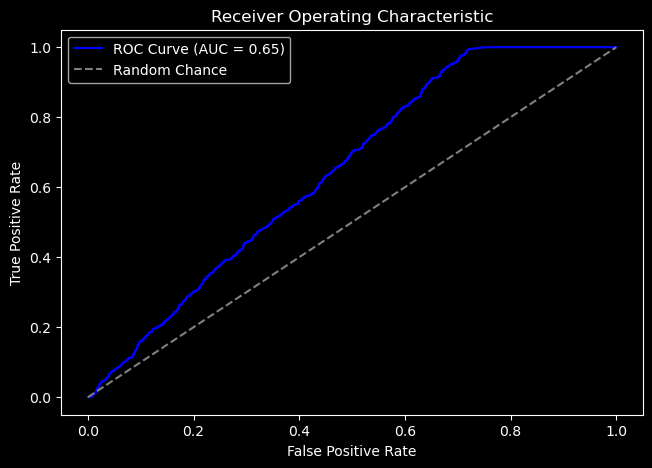

In [ ]:
model_bb_fh_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_fh_time, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_time_w, plot=True)

2025-09-02 00:08:23.734 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Triple Barrier Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2736
           1       0.06      1.00      0.11       173

    accuracy                           0.06      2909
   macro avg       0.03      0.50      0.06      2909
weighted avg       0.00      0.06      0.01      2909


Confusion Matrix:
[[   0 2736]
 [   0  173]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.53      0.69      2736
           1       0.09      0.74      0.16       173

    accuracy                           0.54      2909
   macro avg       0.53      0.64      0.42      2909
weighted avg       0.92      0.54      0.65      2909


Confusion Matrix:
[[1451 1285]
 [  45  128]]


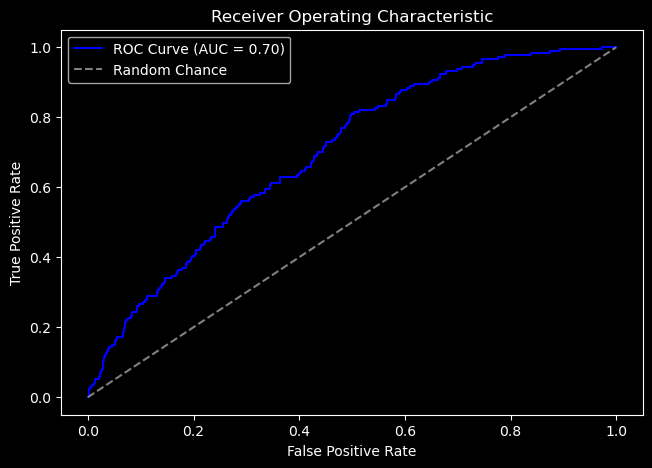

In [ ]:
model_bb_tbl_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_tbl_time, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_time_w, plot=True)

Samples weighted by t-value.
2025-09-02 00:08:45.739 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1572
           1       0.46      1.00      0.63      1337

    accuracy                           0.46      2909
   macro avg       0.23      0.50      0.31      2909
weighted avg       0.21      0.46      0.29      2909


Confusion Matrix:
[[   0 1572]
 [   0 1337]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.90      0.31      0.46      1572
           1       0.54      0.96      0.69      1337

    accuracy                           0.61      2909
   macro avg       0.72      0.63      0.57      2909
weighted avg       0.73      0.61      0.56      2909


Confusion Matrix:
[[ 481 1091]
 [  56 1281]]


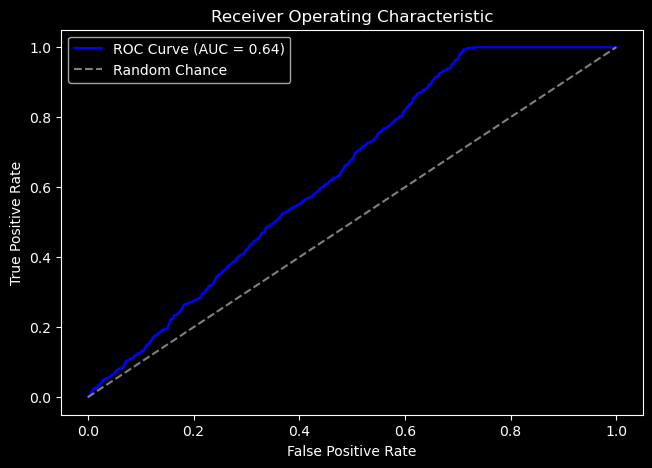

In [ ]:
model_bb_trend_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_time, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_time_w, plot=True)

Reloading 'notebooks.training'.
Samples weighted by t-value.
2025-09-02 00:09:10.821 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2688
           1       0.08      1.00      0.14       221

    accuracy                           0.08      2909
   macro avg       0.04      0.50      0.07      2909
weighted avg       0.01      0.08      0.01      2909


Confusion Matrix:
[[   0 2688]
 [   0  221]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26      2688
           1       0.09      1.00      0.16       221

    accuracy                           0.22      2909
   macro avg       0.54      0.58      0.21      2909
weighted avg       0.93      0.22      0.26      2909


Confusion Matrix:
[[ 408 2280]


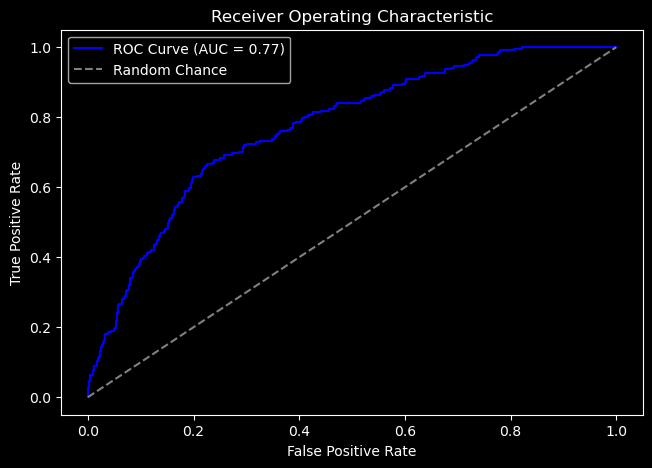

In [ ]:
model_bb_trend_mr_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_mr_time, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_mr_time_w, plot=True)

###### Time-Decay Weighted

In [ ]:
model_bb_fh_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_fh_time, 
    weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_fh_time_tw, plot=True)

------------------------------------------------------------
Fixed-Time Horizon Evaluation Report:
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1640
           1       0.44      1.00      0.61      1269

    accuracy                           0.44      2909
   macro avg       0.22      0.50      0.30      2909
weighted avg       0.19      0.44      0.26      2909


Confusion Matrix:
[[   0 1640]
 [   0 1269]]

META-MODEL PERFORMANCE:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.32      0.47      1640
           1       0.51      0.94      0.66      1269

    accuracy                           0.59      2909
   macro avg       0.69      0.63      0.56      2909
weighted avg       0

2025-09-02 00:16:18.524 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Triple Barrier Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2736
           1       0.06      1.00      0.11       173

    accuracy                           0.06      2909
   macro avg       0.03      0.50      0.06      2909
weighted avg       0.00      0.06      0.01      2909


Confusion Matrix:
[[   0 2736]
 [   0  173]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      2736
           1       0.13      0.71      0.21       173

    accuracy                           0.69      2909
   macro avg       0.55      0.70      0.51      2909
weighted avg       0.92      0.69      0.77      2909


Confusion Matrix:
[[1894  842]
 [  51  122]]


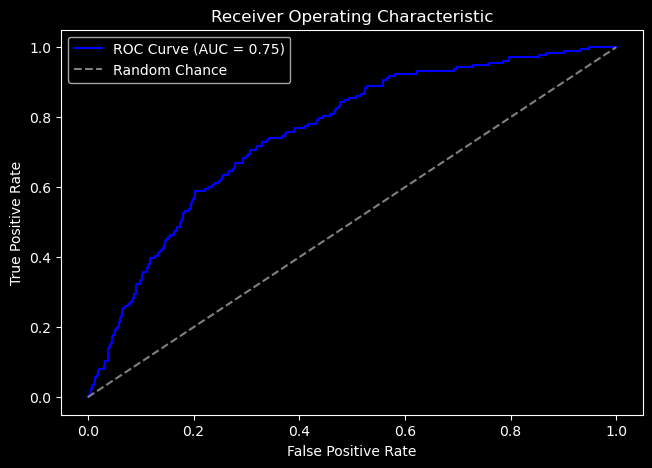

In [ ]:
model_bb_tbl_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_tbl_time, 
    weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_tbl_time_tw, plot=True)

2025-09-02 00:16:40.212 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1572
           1       0.46      1.00      0.63      1337

    accuracy                           0.46      2909
   macro avg       0.23      0.50      0.31      2909
weighted avg       0.21      0.46      0.29      2909


Confusion Matrix:
[[   0 1572]
 [   0 1337]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.85      0.32      0.47      1572
           1       0.54      0.93      0.68      1337

    accuracy                           0.60      2909
   macro avg       0.69      0.63      0.57      2909
weighted avg       0.71      0.60      0.57      2909


Confusion Matrix:
[[ 506 1066]
 [  91 1246]]


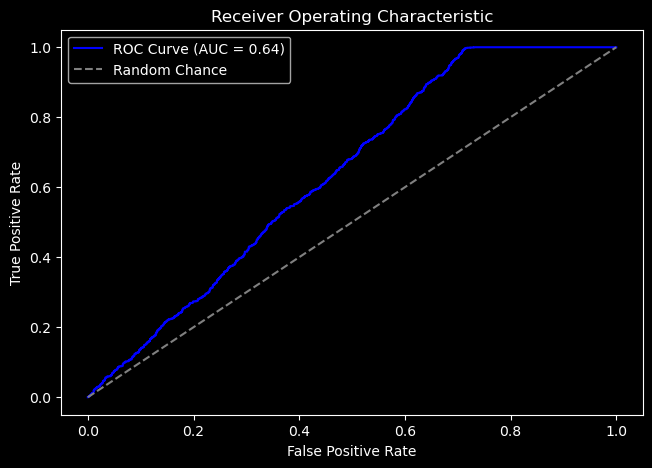

In [ ]:
model_bb_trend_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_trend_time, 
    weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_time_tw, plot=True)

In [ ]:
model_bb_trend_mr_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_trend_mr_time, 
    weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_bb_trend_mr_time_tw, plot=True)

------------------------------------------------------------
TREND-SCANNING (MEAN-REVERSION) EVALUATION REPORT:
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2688
           1       0.08      1.00      0.14       221

    accuracy                           0.08      2909
   macro avg       0.04      0.50      0.07      2909
weighted avg       0.01      0.08      0.01      2909


Confusion Matrix:
[[   0 2688]
 [   0  221]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2688
           1       0.46      0.93      0.61       221

    accuracy                           0.91      2909
   macro avg       0.73      0.92      0.78      2909
weighted avg       0.

Reports

In [ ]:
dirpath = Path("reports", "time_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_time_horizon})", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon})", 
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh_time, model_ma_tbl_time, model_ma_trend_time, model_ma_trend_mr_time]
ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labelling_classification_reports(model_data=model_ma_fh_time, title="Fixed-Time Horizon", output_filename=dirpath / "ma_fixed_time")
meta_labelling_classification_reports(model_data=model_ma_tbl_time, title="Triple Barrier", output_filename=dirpath / "ma_triple_barrier")
meta_labelling_classification_reports(model_data=model_ma_trend_time, title=f"Trend-Scanning (σ = {volatility_threshold})", 
                                      output_filename=dirpath / "ma_trend_scanning")
meta_labelling_classification_reports(model_data=model_ma_trend_mr_time, title=f"Trend-Scanning (σ = {volatility_threshold_mr})", 
                                      output_filename=dirpath / "ma_trend_scanning_mr")

##### Tick-Bars

In [ ]:
model_ma_fh_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_fh_tick)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_ma_fh_tick, plot=True)

In [ ]:
model_ma_tbl_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_tbl_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_ma_tbl_tick, plot=True)

In [ ]:
model_ma_trend_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_trend_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_ma_trend_tick, plot=True)

In [ ]:
model_ma_trend_mr_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_trend_mr_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labelling_reports(model_ma_trend_mr_tick, plot=True)

In [ ]:
dirpath = Path("reports", "tick_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_tick_horizon} minutes)", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_tick_horizon})", 
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh_tick, model_ma_tbl_tick, model_ma_trend_tick, model_ma_trend_mr_tick]
ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labelling_classification_reports(model_data=ma_models, title=bb_titles, output_filename=dirpath / "ma_fixed_tick")